## GoogLinput_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_projeNet a.k.a Inception V1

Google Net (or Inception V1) was proposed by research at Google (with the collaboration of various universities) in 2014 in the research paper titled “Going Deeper with Convolutions”. This architecture was the winner at the ILSVRC 2014 image classification challenge. It has provided a significant decrease in error rate as compared to previous winners AlexNet (Winner of ILSVRC 2012) and ZF-Net (Winner of ILSVRC 2013) and significantly less error rate than VGG (2014 runner up). This architecture uses techniques such as 1×1 convolutions in the middle of the architecture and global average pooling.

In [23]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
from datetime import datetime

!pip3 install torchviz
from torchviz import make_dot

### 1) Building the Architecture

#### Inception Module

In [24]:
class Inception(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super().__init__()
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )
        
        #1x1conv -> 3x3conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )
        
        #1x1conv -> 5x5conv branch
        #we use 2 3x3 conv filters stacked instead
        #of 1 5x5 filters to obtain the same receptive
        #field with fewer parameters
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )
        
        #3x3pooling -> 1x1conv
        #same conv
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)

#### Making a Inception V1

In [25]:
class GoogLeNet(nn.Module):
    def __init__(self, num_class=100):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )
        #although we only use 1 conv layer as prelayer,
        #we still use name a3, b3.......
        
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        #"""In general, an Inception network is a network consisting of
        #modules of the above type stacked upon each other, with occasional
        #max-pooling layers with stride 2 to halve the resolution of the
        #grid"""
        
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        #input feature size: 8*8*1024
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)
        
    def forward(self, x):
        output = self.prelayer(x)
        output = self.a3(output)
        output = self.b3(output)

        output = self.maxpool(output)

        output = self.a4(output)
        output = self.b4(output)
        output = self.c4(output)
        output = self.d4(output)
        output = self.e4(output)

        output = self.maxpool(output)

        output = self.a5(output)
        output = self.b5(output)

        #"""It was found that a move from fully connected layers to
        #average pooling improved the top-1 accuracy by about 0.6%,
        #however the use of dropout remained essential even after
        #removing the fully connected layers."""
        output = self.avgpool(output)
        output = self.dropout(output)
        output = output.view(output.size()[0], -1)
        logits = self.linear(output)
        probs = F.softmax(logits, dim=1)
       

        return logits, probs

        

In [26]:
googLeNet = GoogLeNet()


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [28]:
googLeNet = googLeNet.to(device)

In [29]:
if device == 'cuda':
    googLeNet = nn.DataParallel(googLeNet)
    torch.backends.cudnn.benchmark = True

In [30]:
print(googLeNet)

DataParallel(
  (module): GoogLeNet(
    (prelayer): Sequential(
      (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (a3): Inception(
      (b1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (b2): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (b3): Sequential(
        (0): Conv2d(192, 16, kernel_s

In [31]:
x = torch.zeros(1, 3, 32, 32, dtype=torch.float, requires_grad=False)
out = googLeNet(x)

In [32]:
make_dot(out).render("InceptionV1", format="png")

'InceptionV1.png'

In [33]:
summary(googLeNet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 32, 32]           5,376
       BatchNorm2d-2          [-1, 192, 32, 32]             384
              ReLU-3          [-1, 192, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          12,352
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 96, 32, 32]          18,528
       BatchNorm2d-8           [-1, 96, 32, 32]             192
              ReLU-9           [-1, 96, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         110,720
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           3,088
      BatchNorm2d-14           [-1, 16,

### 2) Data Preparation

In [34]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [35]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


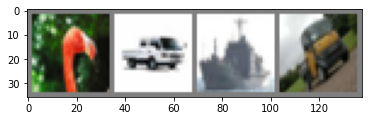

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [37]:
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
epochs = 20

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googLeNet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay,  nesterov=True)

### 3) Training

In [41]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [42]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [43]:

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [44]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
model, optimizer, _ = training_loop(googLeNet, criterion, optimizer, train_loader, test_loader, epochs, device)

10:00:06 --- Epoch: 0	Train loss: 1.6775	Valid loss: 1.1883	Train accuracy: 58.55	Valid accuracy: 56.95
10:02:46 --- Epoch: 1	Train loss: 1.0448	Valid loss: 1.0384	Train accuracy: 65.40	Valid accuracy: 63.02
10:05:26 --- Epoch: 2	Train loss: 0.8509	Valid loss: 0.8558	Train accuracy: 72.99	Valid accuracy: 69.72
10:08:05 --- Epoch: 3	Train loss: 0.7265	Valid loss: 0.7908	Train accuracy: 76.01	Valid accuracy: 72.66
10:10:45 --- Epoch: 4	Train loss: 0.6258	Valid loss: 0.7520	Train accuracy: 78.63	Valid accuracy: 73.66
10:13:25 --- Epoch: 5	Train loss: 0.5486	Valid loss: 0.6658	Train accuracy: 82.84	Valid accuracy: 76.86
10:16:05 --- Epoch: 6	Train loss: 0.4845	Valid loss: 0.6197	Train accuracy: 85.38	Valid accuracy: 78.81
10:18:44 --- Epoch: 7	Train loss: 0.4252	Valid loss: 0.9184	Train accuracy: 78.24	Valid accuracy: 71.73
10:21:24 --- Epoch: 8	Train loss: 0.3748	Valid loss: 0.6703	Train accuracy: 85.18	Valid accuracy: 78.11
10:24:04 --- Epoch: 9	Train loss: 0.3336	Valid loss: 0.5782	Trai